# TSMixer
### Implementation and Evalution

In this workbook the TSMixer model will be used to forecasting the timeseries from a machine called chopper.<br>
The active power get forecasted.<br>
<br>
There is no implementtion of the TSMixer yet, so we have to program it by ourselfs. Propably there is a model on hugginface.

- [System](#system)
- [Imports](#imports)
- [Load Data](#load-data)
- [Load Model](#load-model)
- [Create Model](#create-model)
- [First Try](#first-try)
- [Hyperparameter Tuning](#hyperparameter-tuning)
- [Evaluaton](#evaluation)
- [Ressources](#ressources)

---
### System

- Python-Version: 3.9.1
- OS: Windows 11
- Packages:
    - ipykernel
    - numpy
    - pandas
    - matplotlib
    - holidays
    - (torch-directml) -> not used
- CPU: AMD Ryzen 7 3700X 8-Core Processor, 3600 MHz, 8 kernels, 16 logical processors
- GPU: AMD Radeon (TM) R9 Fury Series
    - Not used
- RAM 32GB

---
### Imports

-> https://pypi.org/project/torch-directml/

In [1]:
!python --version

Python 3.9.1


In [2]:
# !python -m pip install numpy
# !python -m pip install pandas
# !python -m pip install matplotlib
# !python -m pip install scikit-learn
# !python -m pip install holidays
# !python -m pip install torch-directml
# !python -m pip install torch torchvision torchaudio

In [3]:
from helper import Helper

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from datetime import datetime as dt
import pickle

---
### Load Data

In [4]:
helper = Helper(dir_path=Helper.DIR_PATH)

Loading data from the Chopper...
Tries to load from directory '../../../data/chopper'
        -> Absolute-Path: 'd:\Studium\7. Semester\Module\KI-Projekt_Energiemangement\data\chopper'
        -> Successfully loaded 3 files
Loading data from the Conveyor...
Tries to load from directory '../../../data/conveyor'
        -> Absolute-Path: 'd:\Studium\7. Semester\Module\KI-Projekt_Energiemangement\data\conveyor'
        -> Successfully loaded 10 files

Helper succefully created 🥳


Informations:

CHOPPER
    -> Frequency: 1min
    -> Idle Performance: -49000 Watt
    -> Max Performance: 1886000 Watt
    -> Min-Max Mass-Flow: [0, 2000]
    -> Rows: 130453
    -> Columns: ['Zeitstempel', 'Blindarbeit', 'Ges. Blindleistung', 'Ges. Scheinleistung', 'Ges. Wirkleistung', 'Spannung L1', 'Spannung L2', 'Spannung L3', 'Strom L1', 'Strom L2', 'Strom L3', 'Wirkarbeit']
    -> Time: 13.09.2023 (11:41) - 13.12.2023 (09:59)


CONVEYOR_BELT
    -> Frequency: 1min
    -> Idle Performance: 13500 Watt
    -

In [5]:
df_chopper, df_conveyor = helper.get_data()

In [6]:
target_idx = df_chopper.columns.get_loc(helper.TARGET)
target_slice = slice(target_idx, target_idx + 1)
target_slice

slice(4, 5, None)

Make a data splt

In [7]:
train, dev, test = helper.train_dev_test_split(data=df_chopper, 
                                                train_start_day="13.09.2023", train_end_day="19.11.2023",
                                                dev_start_day="20.11.2023", dev_end_day="27.11.2023",
                                                test_start_day="28.11.2023", test_end_day="10.12.2023",
                                                should_seperate_target=False)

Train Data: 96781
     -> 13.09.2023 (11:41) - 19.11.2023 (23:59)
Dev Data: 11509
     -> 20.11.2023 (00:00) - 27.11.2023 (23:59)
Test Data: 18689
     -> 28.11.2023 (00:00) - 10.12.2023 (23:59)


Create Features

In [8]:
features = Helper.FEATURE_SET_6
train_X, dev_X = helper.create_features(data=train, features=features, application_df=dev)
_, test_X = helper.create_features(data=pd.concat([train, dev], axis=0), features=features, application_df=test, use_tsmixer=False)

In [9]:
train_X.columns

Index(['SECOND', 'MINUTE', 'HOUR', 'MONTH', 'DAY_OF_THE_YEAR',
       'DAY_OF_THE_WEEK', 'WEEK_OF_THE_YEAR', 'WEEK_OF_THE_MONTH',
       'WORKING_DAY', 'MASS_FLOW'],
      dtype='object')

Merge

In [10]:
train = pd.concat([train_X, train[helper.TARGET]], axis=1)
dev = pd.concat([dev_X, dev[helper.TARGET]], axis=1)
test = pd.concat([test_X,  test[helper.TARGET]], axis=1)

Normalization

reverse normalization only, when you predcted and will give the predictions away

In [11]:
# scaler = StandardScaler()
# scaler = scaler.fit(train.values)

# train = pd.DataFrame(scaler.transform(train.values), index=train.index, columns=train.columns)
# dev = pd.DataFrame(scaler.transform(dev.values), index=dev.index, columns=dev.columns)
# test = pd.DataFrame(scaler.transform(test.values), index=test.index, columns=test.columns)

Target Split

In [12]:
train_X = train.drop(columns=(helper.TARGET))
train_y = train.loc[:, helper.TARGET]

dev_X = dev.drop(columns=(helper.TARGET))
dev_y = dev.loc[:, helper.TARGET]

test_X = test.drop(columns=(helper.TARGET))
test_y = test.loc[:, helper.TARGET]

change to torch format

In [13]:
train_X_tensor = torch.tensor(train_X.values.astype("int"), dtype=torch.float32).float()
train_y_tensor = torch.tensor(train_y.values.astype("int"), dtype=torch.float32).float()
dev_X_tensor = torch.tensor(dev_X.values.astype("int"), dtype=torch.float32).float()
dev_y_tensor = torch.tensor(dev_y.values.astype("int"), dtype=torch.float32).float()
test_X_tensor = torch.tensor(test_X.values.astype("int"), dtype=torch.float32).float()
test_y_tensor = torch.tensor(test_y.values.astype("int"), dtype=torch.float32).float()

train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
dev_dataset = TensorDataset(dev_X_tensor, dev_y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_y_tensor)

BATCH_SIZE = helper.PREDICTION_PERIOD # 164
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Check shape

-> there is one wrong shape

In [14]:
count = 0
batch_x_shapes = []
for batch_X, batch_y in train_loader:
    if count == 3:
        if batch_x_shapes[0] == batch_x_shapes[1] == batch_x_shapes[2]:
            COMMON_BATCH_SHAPE = batch_x_shapes[0]
            N_FEATURES = batch_x_shapes[0][-1]
        else:
            raise ValueError("The batches have another shape! Try to run the code again.")
    if count < 3:
        print("X:", batch_X.shape)
        batch_x_shapes += [batch_X.shape]
        print("y:", batch_y.shape, "\n")
    else:
        if batch_X.shape != COMMON_BATCH_SHAPE:
            print("Warning:", batch_X.shape, "On batch count:", count)
    count += 1

print("\nAmount Batches:", count, "\nCalculated:", len(train.index)//BATCH_SIZE)
N_BATCHES = count
print("Features:", N_FEATURES)

X: torch.Size([1440, 10])
y: torch.Size([1440]) 

X: torch.Size([1440, 10])
y: torch.Size([1440]) 

X: torch.Size([1440, 10])
y: torch.Size([1440]) 


Amount Batches: 68 
Calculated: 67
Features: 10


correct shape

In [15]:
# def filter_loader(loader, common_X_shape):
#     filtered_loader = []
#     for cur_batch in loader:
#         batch_X, batch_y = cur_batch
#         if batch_X.shape == common_X_shape:
#             filtered_loader += [cur_batch]
#     return DataLoader(filtered_loader)

In [16]:
# train_loader = filter_loader(train_loader, common_batch_shape)
# dev_loader = filter_loader(dev_loader, common_batch_shape)
# test_loader = filter_loader(test_loader, common_batch_shape)

Format: [Batch, Input Length, Channels]

"Batch" die Anzahl der Beispiele in einem Batch ist

"Channels" die Anzahl der verschiedenen Zeitreihen oder Features repräsentiert, die für die Vorhersage verwendet werden

"Input Length" die Anzahl der Zeitschritte in jeder Zeitreihe ist

Example for the format:

```python
[
# 1. batch    
[   # 1. Input
    [12, 232, 676],     # Features/Channels
    # 2. Input
    [12, 232, 676],     # Features/Channels
    # 3. Input
    [12, 232, 676]],    # Features/Channels

# 2. batch
[   # 1. Input
    [12, 232, 676],     # Features/Channels
    # 2. Input
    [12, 232, 676],     # Features/Channels
    # 3. Input
    [12, 232, 676]],    # Features/Channels

# 3. batch
[   # 1. Input
    [12, 232, 676],     # Features/Channels
    # 2. Input
    [12, 232, 676],     # Features/Channels
    # 3. Input
    [12, 232, 676]]     # Features/Channels
]
```


---
### Create Model

-> Heavenly inspired from [official implementation](https://github.com/google-research/google-research/blob/master/tsmixer/tsmixer_basic/models/tsmixer.py)

Here the code provided from google in tensorflow:

\>\>\> Code start <<<
```python
# coding=utf-8
# Copyright 2023 The Google Research Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Implementation of TSMixer."""

import tensorflow as tf
from tensorflow.keras import layers


def res_block(inputs, norm_type, activation, dropout, ff_dim):
  """Residual block of TSMixer."""

  norm = (
      layers.LayerNormalization
      if norm_type == 'L'
      else layers.BatchNormalization
  )

  # Temporal Linear
  x = norm(axis=[-2, -1])(inputs)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(x.shape[-1], activation=activation)(x)
  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Input Length, Channel]
  x = layers.Dropout(dropout)(x)
  res = x + inputs

  # Feature Linear
  x = norm(axis=[-2, -1])(res)
  x = layers.Dense(ff_dim, activation=activation)(
      x
  )  # [Batch, Input Length, FF_Dim]
  x = layers.Dropout(dropout)(x)
  x = layers.Dense(inputs.shape[-1])(x)  # [Batch, Input Length, Channel]
  x = layers.Dropout(dropout)(x)
  return x + res


def build_model(
    input_shape,
    pred_len,
    norm_type,
    activation,
    n_block,
    dropout,
    ff_dim,
    target_slice,
):
  """Build TSMixer model."""

  inputs = tf.keras.Input(shape=input_shape)
  x = inputs  # [Batch, Input Length, Channel]
  for _ in range(n_block):
    x = res_block(x, norm_type, activation, dropout, ff_dim)

  if target_slice:
    x = x[:, :, target_slice]

  x = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Channel, Input Length]
  x = layers.Dense(pred_len)(x)  # [Batch, Channel, Output Length]
  outputs = tf.transpose(x, perm=[0, 2, 1])  # [Batch, Output Length, Channel])

  return tf.keras.Model(inputs, outputs)
```

\>\>\> Code end <<<

In [15]:
#self.activation = getattr(nn, activation)()

activation_functions = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "laekyrelu": nn.LeakyReLU
}

class ResBlock(nn.Module):
    """
    Residual block for TSMixer.

    Parameters:
    - norm_type (str): Type of normalization, either 'L' for LayerNorm or 'B' for BatchNorm.
    - activation (str): Activation function to be used.
    - dropout (float): Dropout rate for regularization.
    - ff_dim (int): Dimension of the feature linear layer.

    Attributes:
    - norm: Normalization layer.
    - temporal_linear: Temporal linear layer.
    - feature_linear: Feature linear layer.
    """

    def __init__(self, input_shape, norm_type, activation, dropout, ff_dim):
        super(ResBlock, self).__init__()

        # define normalization
        self.norm = (
            nn.LayerNorm
            if norm_type == 'L'
            else nn.BatchNorm1d
        )

        # Temporal Linear
        self.temporal_linear = nn.Sequential(
            self.norm(input_shape[-2]),  
            nn.Linear(input_shape[-2], input_shape[-2]), 
            activation_functions[activation](),
            nn.Dropout(dropout)
        )
        
        # Feature Linear
        self.feature_linear = nn.Sequential(
            self.norm(input_shape[-1]),   
            nn.Linear(input_shape[-1], ff_dim),    
            activation_functions[activation](),
            nn.Dropout(dropout),
            nn.Linear(ff_dim, input_shape[-1]),   
            nn.Dropout(dropout)
        )

    def forward(self, inputs):
        """
        Forward pass through the residual block.

        Parameters:
        - inputs (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        x = inputs
        # Temporal Linear
        x = x.transpose(1, 0)  # switch to -> [Channel, Input Length]
        x = self.temporal_linear(x)
        x = x.transpose(1, 0)  # switch to -> [Input Length, Channel]
        res = x + inputs

        # Feature Linear
        #x = res.transpose(1, 2)  # [Input Length, Channel]
        x = self.feature_linear(x)
        #x = x.transpose(1, 2)  # [Channel, Input Length]

        return x + res

class TSMixerModel(nn.Module):
    """
    TSMixer model.

    Parameters:
    - input_shape (int): Input shape.
    - pred_len (int): Length of the prediction.
    - norm_type (str): Type of normalization, either 'L' for LayerNorm or 'B' for BatchNorm.
    - activation (str): Activation function to be used.
    - n_block (int): Number of residual blocks in the model.
    - dropout (float): Dropout rate for regularization.
    - ff_dim (int): Dimension of the feature linear layer.
    - target_slice (int or None): Index of the target slice or None.

    Attributes:
    - blocks: List of residual blocks.
    - target_slice: Index of the target slice.
    - output_layer: Output linear layer.
    """

    def __init__(self, input_shape, pred_len, norm_type, activation, n_block, dropout, ff_dim, target_slice):
        super(TSMixerModel, self).__init__()

        self.blocks = nn.ModuleList([
            ResBlock(input_shape, norm_type, activation, dropout, ff_dim) for _ in range(n_block)
        ])

        self.target_slice = target_slice

        self.output_layer = nn.Sequential(
            nn.Linear(input_shape[-2], pred_len)
        )

        self.output_feature_reduction_layer = nn.Sequential(
            nn.Linear(input_shape[-1], 1)
        )

    def forward(self, x):
        """
        Forward pass through the TSMixer model.

        Parameters:
        - x (torch.Tensor): Input tensor.

        Returns:
        - torch.Tensor: Output tensor.
        """
        for block in self.blocks:
            x = block(x)

        if self.target_slice:
            x = x[:, self.target_slice]

        x = x.transpose(1, 0)  # [Channel, Input Length]
        x = self.output_layer(x)  # [Channel, Output Length]
        x = x.transpose(1, 0)  # [Output Length, Channel]
        x = self.output_feature_reduction_layer(x)

        #x = x.mean(dim=0)

        return x

Model works?

In [18]:
input_shape = [BATCH_SIZE, N_FEATURES]   # batches = N_BATCHES
pred_len = BATCH_SIZE #helper.PREDICTION_PERIOD
norm_type = 'L'
activation = 'laekyrelu'
n_block = 3    # amount of resdual blocks
dropout = 0.4
ff_dim = 64     # feature dimenson amount for projection
target_slice = None    # specifc feature/time dimenson?

model = TSMixerModel(input_shape, pred_len, norm_type, activation, n_block, dropout, ff_dim, target_slice)

input_data = torch.randn(input_shape)

# test
output = model(input_data)
print(output.shape)  # Output: [Output Length, Channel]

torch.Size([1440, 1])


In [19]:
output.squeeze().shape

torch.Size([1440])

---
### Train function

In [20]:
def get_short_duration_representation(start, end, should_print=False):
    duration = abs((start-end).total_seconds())
    minutes, seconds = divmod(duration, 60)
    hours, minutes = divmod(minutes, 60)
    days, hours = divmod(hours, 24)
    res = f"{int(days)}D {int(hours)}H {int(minutes)}M {int(seconds)}S"
    if should_print:
        print(res)
    return res

In [21]:
def train(epochs=20, learning_rate=1e-4, n_block=3, ff_dim=64, 
            dropout=0.1, activation='laekyrelu', optimizer_name=optim.Adam, 
            criterion_name=nn.MSELoss, save_path="./results/tsmixer_experiment",
            experiment_name="TSMixer", should_save=False, show_res=False):

    # create TSMixer-Modell
    input_shape = [BATCH_SIZE, N_FEATURES]  
    pred_len = BATCH_SIZE #helper.PREDICTION_PERIOD  
    norm_type = 'L'
    target_slice = None    # not in use
    criterion = criterion_name()
    log = ""

    model = TSMixerModel(input_shape, pred_len, norm_type, activation, n_block, dropout, ff_dim, target_slice)

    optimizer = optimizer_name(model.parameters(), lr=learning_rate)

    start = dt.now()

    start_str = f'\n\n{"#"*16}\nExperiment:\n    - name = {experiment_name}\
    \n    - start = {start.strftime("%Y-%m-%d %H:%M OClock")}\n    - learn-rate = {learning_rate}\
    \n    - epochs = {epochs}\n    - n_blocks = {n_block}\n    - ff_dim = {ff_dim}\
    \n    - dropout = {dropout}\n    - activation = {activation}\
    \n    - criterion = {criterion_name.__name__}\n    - optimizer = {optimizer_name.__name__}'
    log += start_str
    if show_res:
        print(start_str)

    # training
    loss_hist = []
    steps = 0
    log = ""

    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            if batch_X.shape == COMMON_BATCH_SHAPE:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)  
                loss_hist += [loss.item()]
                loss.backward()
                optimizer.step()
                steps += 1

        epoch_str = f'-> Epoch {epoch+1}/{epochs}, Training Loss: {loss.item():.4f}, Steps: {steps}'
        log += f"\n{epoch_str}"
        if show_res:
            print(epoch_str)
    last_loss = loss.item()

    end_str = f"Training Finish, duration = {get_short_duration_representation(start=start, end=dt.now())}"
    log += f"\n\n{end_str}"
    if show_res:
        print(end_str)

    log += f"\n\nLast loss: {last_loss}"

    # draw it
    if show_res == False:
        plt.ioff()

    loss_series = pd.Series(loss_hist)
    window_size = 100 
    loss_rolling = loss_series.rolling(window=window_size).mean()

    if show_res or should_save:
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))
        #ax.plot(np.arange(len(loss_hist)), loss_hist, label='Original Loss')
        ax.plot(np.arange(len(loss_series.index)), loss_rolling, label='Smoothed Loss', linewidth=2)
        ax.set_xlabel('Learning progress')
        ax.set_ylabel('Loss (normalized mean absolute error)')
        ax.set_title('Loss over time')
        ax.legend()
        ax.grid()
        if show_res:
            plt.show()

        if should_save:
            plt.savefig(f"{save_path}/{experiment_name}_loss.png")

    # testing on dev-data
    avg_dev_loss = test_data(model, dataloader=dev_loader, save_path=save_path, 
                                    experiment_name=experiment_name, should_save=should_save, 
                                    show_res=show_res, criterion_name=criterion_name)

    log += f"\n\nAVG Dev loss: {avg_dev_loss}"

    # save experiment results
    if should_save:
        with open(f"{save_path}/{experiment_name}_log.txt", "w") as f:
            f.write(log)

    return model, log, last_loss, avg_dev_loss

In [22]:
def test_data(model, dataloader, save_path="./results/tsmixer_experiment",
                experiment_name="TSMixer", should_save=False, show_res=True,
                show_residuals=False, criterion_name=nn.MSELoss,
                window_size=25):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    got_example_predicton = False
    example_y_pred = None
    example_y = None
    timesteps = None
    loss_hist = []
    criterion = criterion_name()

    with torch.no_grad():
        amount = 0
        for batch_X, batch_y in dataloader:
            if batch_X.shape == COMMON_BATCH_SHAPE:
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                total_loss += loss.item()
                loss_hist += [loss.item()]

                all_predictions += [outputs.squeeze().numpy()]
                amount += 1

                if got_example_predicton == False:
                    if np.random.rand() > 0.1:
                        example_y_pred = outputs.squeeze().numpy()
                        example_y = batch_y
                        time_steps = np.arange(len(batch_y))
                        got_example_predicton = True

    if got_example_predicton == False:
        example_y_pred = outputs.squeeze().numpy()
        example_y = batch_y
        time_steps = np.arange(len(batch_y))
        got_example_predicton = True


    average_loss = total_loss / amount
    if show_res:
        print(f'Average Loss: {average_loss:.4f}')
    else:
        plt.ioff()

    if show_res or should_save:
        fig, ax = plt.subplots(1, 1, figsize=(16, 8))

        # plot the timeseries
        example_y = pd.Series(example_y)
        example_y_pred = pd.Series(example_y_pred)
        example_y = example_y.rolling(window=window_size).mean()
        example_y_pred = example_y_pred.rolling(window=window_size).mean()

        ax.plot(np.arange(len(example_y.index)), example_y, label='Ground Truth', marker='o')
        ax.plot(np.arange(len(example_y_pred.index)), example_y_pred, label='Predictions', marker='x', alpha=0.6)
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Values')
        ax.set_title(f'Time Series Predictions on data (AVG={average_loss:.4f})')
        ax.legend()
        ax.grid(True, linestyle='--', alpha=0.7)

    if show_res:
        plt.show()

    if should_save:
        plt.savefig(f"{save_path}/{experiment_name}_example_test_prediction.png")


    # residuals
    if show_residuals:
        if show_res or should_save:
            fig, ax = plt.subplots(1, 1, figsize=(16, 8))
            ax.hist(loss_hist, bins=15, color='green', edgecolor='black')
            ax.set_xlabel(f'Loss ({criterion})')
            ax.set_ylabel('Amount of values with this loss')
            ax.set_title('Losses')
            ax.grid()

            if show_res:
                plt.show()

            if should_save:
                plt.savefig(f"{save_path}/{experiment_name}_residuals.png")

    return average_loss, total_loss

---
### First Test



################
Experiment:
    - name = TSMixer    
 start = 2024-01-10 12:17 OClock
    - learn-rate = 0.0001    
    - epochs = 20
    - n_blocks = 3
    - ff_dim = 64    
    - dropout = 0.1
    - activation = laekyrelu    
    - criterion = MSELoss
    - optimizer = Adam
-> Epoch 1/20, Training Loss: 649026496.0000, Steps: 67
-> Epoch 2/20, Training Loss: 626574976.0000, Steps: 134
-> Epoch 3/20, Training Loss: 586568064.0000, Steps: 201
-> Epoch 4/20, Training Loss: 521057952.0000, Steps: 268
-> Epoch 5/20, Training Loss: 434561248.0000, Steps: 335
-> Epoch 6/20, Training Loss: 334454112.0000, Steps: 402
-> Epoch 7/20, Training Loss: 234427456.0000, Steps: 469
-> Epoch 8/20, Training Loss: 140024576.0000, Steps: 536
-> Epoch 9/20, Training Loss: 72521992.0000, Steps: 603
-> Epoch 10/20, Training Loss: 30768330.0000, Steps: 670
-> Epoch 11/20, Training Loss: 20884222.0000, Steps: 737
-> Epoch 12/20, Training Loss: 43511292.0000, Steps: 804
-> Epoch 13/20, Training Loss: 9822868

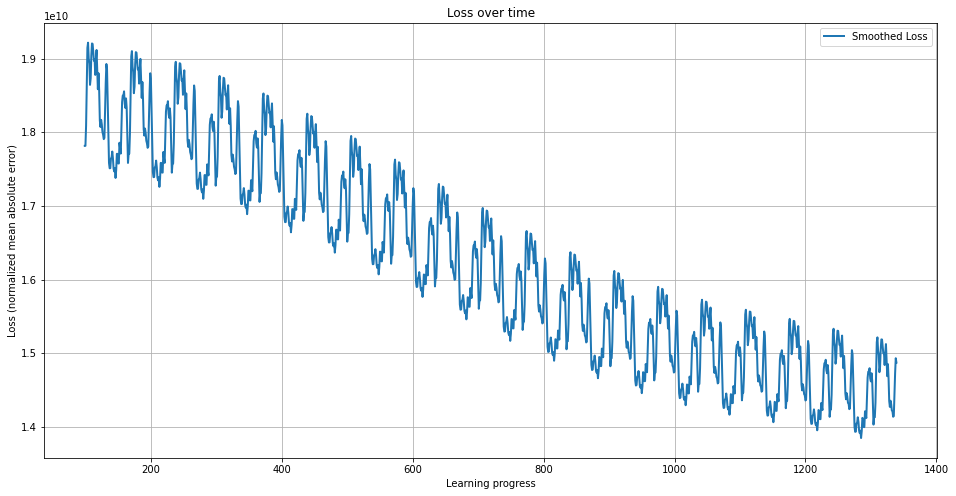

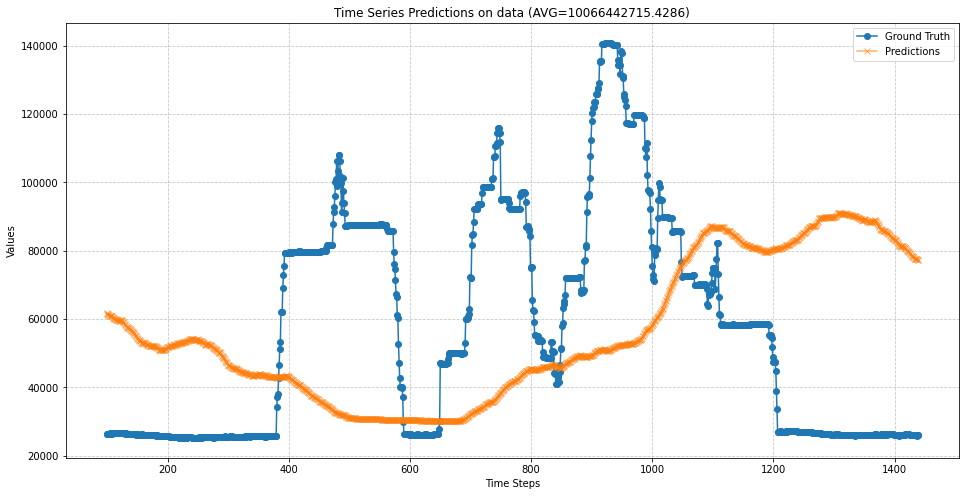

In [53]:
model, log, last_loss, avg_dev_loss = train(epochs=20, learning_rate=1e-4, n_block=3, ff_dim=64, 
                                            dropout=0.1, activation='laekyrelu', optimizer_name=optim.Adam, 
                                            criterion_name=nn.MSELoss, save_path="./results/tsmixer_experiment",
                                            experiment_name="TSMixer", should_save=False, show_res=False)

testing on test-data

Average Loss: 13793163312.0000


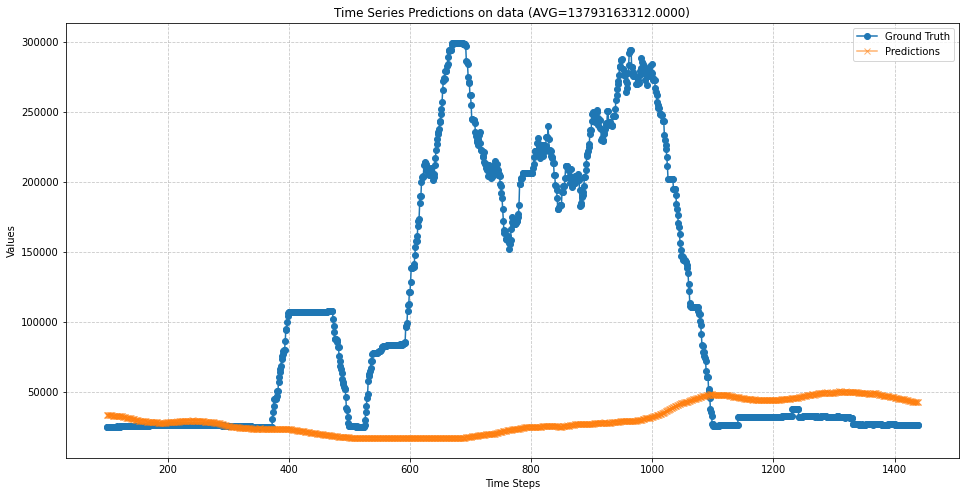

13793163312.0

In [55]:
test_data(model, test_loader, save_path="./results/tsmixer_experiment",
                experiment_name="TSMixer", should_save=False, show_res=True,
                show_residuals=False, criterion_name=nn.MSELoss)

---
### Hyperparameter Tuning

with gridsearch

In [ ]:
experiment_log = dict()
counter = 0

for cur_epochs in [10, 50, 100]:
    for cur_learning_rate in [1e-3, 1e-4, 1e-5]:
        for n_blocks in [5, 10, 15]:
            experiment_name = f"Nr. {counter}"
            model, log, last_loss, avg_dev_loss = train(epochs=cur_epochs, learning_rate=cur_learning_rate, n_block=n_blocks, ff_dim=64, 
                                                        dropout=0.0, activation='laekyrelu', optimizer_name=optim.Adam, 
                                                        criterion_name=nn.MSELoss, save_path="./results/tsmixer_experiment",
                                                        experiment_name=experiment_name, should_save=True, show_res=False)
            experiment_log[experiment_name] = {
                                                "log":log,
                                                "last_loss": last_loss,
                                                "avg_dev_loss": avg_dev_loss,
                                                "epochs": cur_epochs,
                                                "learning_rate": cur_learning_rate,
                                                "n_blocks": n_blocks,
                                                "dropout": 0.0,
                                                "model": model
                                                }
            counter += 1

with open("./results/tsmixer_experiment/experiment_result.pickle", "wb") as f:
    pickle.dump(experiment_log, f)

test results

In [ ]:
model, log, last_loss, avg_dev_loss = train(epochs=14, learning_rate=0.002135327068087541, n_block=11, ff_dim=89, 
                                            dropout=0.11043381310990708, activation='laekyrelu', optimizer_name=optim.Adam, 
                                            criterion_name=nn.MSELoss, save_path="./results/tsmixer_experiment",
                                            experiment_name="TSMixer", should_save=False, show_res=True)

In [ ]:
test_data(model, test_loader, save_path="./results/tsmixer_experiment",
                experiment_name="TSMixer", should_save=False, show_res=True,
                show_residuals=False, criterion_name=nn.MSELoss, window_size=25)

check_result

In [66]:
experiment_log_sorted = dict(sorted(experiment_log.items(), key=lambda x: x[1]['avg_dev_loss']))
res = ""

for idx, elem in enumerate(experiment_log_sorted.items(), start=1):
    key, values = elem
    cur_res = f"\n\n{idx}. {key}:"

    cur_res += f"\n    - avg dev loss = {values['avg_dev_loss']}"
    cur_res += f"\n    - last loss = {values['last_loss']}"
    cur_res += f"\n    - epochs = {values['epochs']}"
    cur_res += f"\n    - learning_rate = {values['learning_rate']}"
    cur_res += f"\n    - n_blocks = {values['n_blocks']}"
    cur_res += f"\n    - dropout = {values['dropout']}"

    print(cur_res)
    res += cur_res


with open(f"./results/tsmixer_experiment/experiment_results.txt", "w") as f:
    f.write(res)



1. Nr. 25:
    - avg dev loss = 9187735094.857143
    - last loss = 144727280.0
    - epochs = 100
    - learning_rate = 1e-05
    - n_blocks = 10
    - dropout = 0.3


2. Nr. 4:
    - avg dev loss = 9190898057.142857
    - last loss = 368194944.0
    - epochs = 10
    - learning_rate = 0.0001
    - n_blocks = 10
    - dropout = 0.3


3. Nr. 5:
    - avg dev loss = 9521492644.571428
    - last loss = 310415712.0
    - epochs = 10
    - learning_rate = 0.0001
    - n_blocks = 15
    - dropout = 0.3


4. Nr. 12:
    - avg dev loss = 9532989400.428572
    - last loss = 188112496.0
    - epochs = 50
    - learning_rate = 0.0001
    - n_blocks = 5
    - dropout = 0.3


5. Nr. 23:
    - avg dev loss = 9555868406.857143
    - last loss = 217684976.0
    - epochs = 100
    - learning_rate = 0.0001
    - n_blocks = 15
    - dropout = 0.3


6. Nr. 21:
    - avg dev loss = 9668091636.571428
    - last loss = 200608080.0
    - epochs = 100
    - learning_rate = 0.0001
    - n_blocks = 5
    - dr

Average Loss: 24167647253.3333


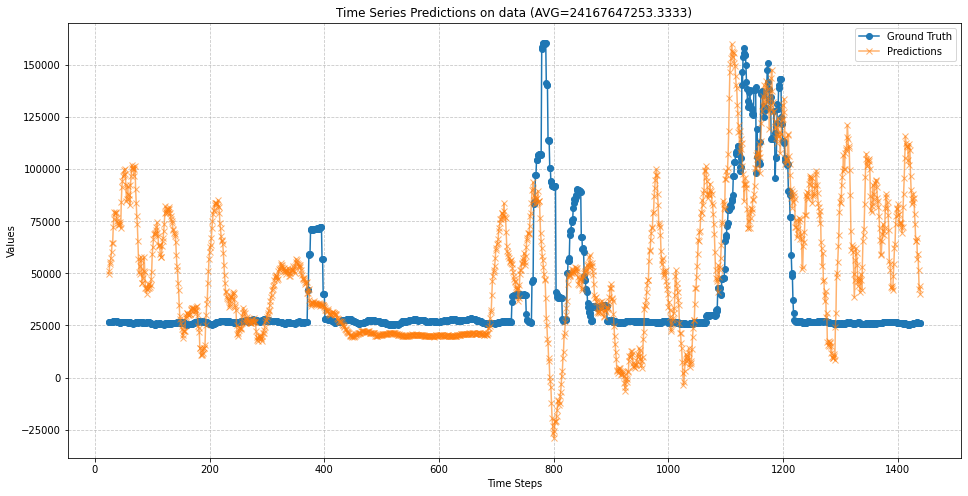

24167647253.333332

In [117]:
test_data(experiment_log["Nr. 18"]["model"], test_loader, save_path="./results/tsmixer_experiment",
                experiment_name="TSMixer", should_save=False, show_res=True,
                show_residuals=False, criterion_name=nn.MSELoss, window_size=25)

---
### Evaluation

=> Test best model on test data

We need MAE and RMSE 

In [16]:
with open('./results/tsmixer_experiment/experiment_result.pickle', 'rb') as f:
    experiment_log = pickle.load(f)

experiment_log["Nr. 25"]

{'log': '\n-> Epoch 1/100, Training Loss: 667245696.0000, Steps: 67\n-> Epoch 2/100, Training Loss: 667392384.0000, Steps: 134\n-> Epoch 3/100, Training Loss: 667490816.0000, Steps: 201\n-> Epoch 4/100, Training Loss: 667484352.0000, Steps: 268\n-> Epoch 5/100, Training Loss: 667308544.0000, Steps: 335\n-> Epoch 6/100, Training Loss: 666858944.0000, Steps: 402\n-> Epoch 7/100, Training Loss: 666228928.0000, Steps: 469\n-> Epoch 8/100, Training Loss: 665316288.0000, Steps: 536\n-> Epoch 9/100, Training Loss: 664068928.0000, Steps: 603\n-> Epoch 10/100, Training Loss: 662468736.0000, Steps: 670\n-> Epoch 11/100, Training Loss: 660502016.0000, Steps: 737\n-> Epoch 12/100, Training Loss: 658017664.0000, Steps: 804\n-> Epoch 13/100, Training Loss: 655027520.0000, Steps: 871\n-> Epoch 14/100, Training Loss: 651529664.0000, Steps: 938\n-> Epoch 15/100, Training Loss: 647419328.0000, Steps: 1005\n-> Epoch 16/100, Training Loss: 642703488.0000, Steps: 1072\n-> Epoch 17/100, Training Loss: 63733

In [17]:
import tsmixer

model, log, total_loss, avg_dev_loss = tsmixer.train(train_loader, epochs=experiment_log["Nr. 25"]["epochs"], learning_rate=experiment_log["Nr. 25"]["learning_rate"], 
                                                    n_block=experiment_log["Nr. 25"]["n_blocks"], ff_dim=64, 
                                                    dropout=experiment_log["Nr. 25"]["dropout"], activation='laekyrelu', optimizer_name=optim.Adam, 
                                                    criterion_name=nn.MSELoss, save_path="",
                                                    experiment_name="Final TSMixer", should_save=False, show_res=False,
                                                    batch_size=BATCH_SIZE, n_features=N_FEATURES, common_batch_shape=COMMON_BATCH_SHAPE,
                                                    test_loader=None)

In [18]:
result = pd.DataFrame(model.predict(test_loader, BATCH_SIZE), columns=["Prediction"], index=test.index)
result

,Prediction
Zeitstempel,
2023-11-28 00:00:00,6875.164062
2023-11-28 00:01:00,5860.042969
2023-11-28 00:02:00,6602.932129
2023-11-28 00:03:00,5506.095703
2023-11-28 00:04:00,6338.667480
...,...
2023-12-10 23:55:00,-12911.203125
2023-12-10 23:56:00,-23100.144531
2023-12-10 23:57:00,-7703.676270


In [20]:
result = result.merge(test[helper.TARGET], right_index=True, left_index=True)

In [21]:
helper.mae(y_true=result[helper.TARGET], y_pred=result["Prediction"])

36651.751372129525

In [22]:
helper.rmse(y_true=result[helper.TARGET], y_pred=result["Prediction"])

113336.68294742572

The model now does more then just a line but still the prediction is very bad. I think with these Input data there is no better result possible.<br>
One problem is that there is no real pattern in the data and another problem is that the mass-flow is bad implemented right now.

Maybe it would be a great idea to try to improve the Mass-Flow feature. Only use high-correlated days, because here the machine of the conveyor should be the right one and also use another prediction method for the conveyor belt prediction.

---
### Ressources

- [Explanation](https://medium.com/ai-advances/understanding-tsmixer-google-ais-new-all-mlp-architecture-for-time-series-forecasting-c7f3f7a7a682)
- [Paper Explanation Abstract](https://seunghan96.github.io/ts/(CL_paper81)TSMixer/)
- [Paper](https://arxiv.org/pdf/2303.06053.pdf)
- [Paper Review](https://andlukyane.com/blog/paper-review-tsmixer)
- [Another Paper Review](https://artgor.medium.com/paper-review-tsmixer-an-all-mlp-architecture-for-time-series-forecasting-346bdb5820a9)
- [Google Page about TSMixer](https://blog.research.google/2023/09/tsmixer-all-mlp-architecture-for-time.html)
- [Github TSMixer implementation in PyTorch](https://github.com/smrfeld/tsmixer-pytorch/tree/main)
- [Medium TSMixer implementation in TensorFlow](https://medium.com/towards-data-science/tsmixer-the-latest-forecasting-model-by-google-2fd1e29a8ccb)
- [GitHub Implementation Official from Google](https://github.com/google-research/google-research/tree/master/tsmixer)
- [unoffical implementation](https://pypi.org/project/pytorch-tsmixer/)

---